In [21]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
from scipy.ndimage import generate_binary_structure, iterate_structure
import librosa
import librosa.display

In [ ]:
def generate_constellation_map(audio_path):
    print(f"Processing {audio_path}...")
    # Load audio
    y, sr = librosa.load(audio_path, sr=22050, mono=True)
    
    # Spectrogram
    D = librosa.stft(y, n_fft=4096, hop_length=1024)
    spectrogram = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # Find Peaks
    neighborhood_size = 20
    local_max = maximum_filter(spectrogram, size=neighborhood_size)
    binary_local_max = (spectrogram == local_max)
    
    # Threshold (Note the -40dB fix!)
    background_threshold = -40 
    detected_peaks = binary_local_max & (spectrogram > background_threshold)

    # Extract indices
    freq_idx, time_idx = np.where(detected_peaks)
    
    # Zip and Sort (Crucial Step for Hashing)
    peaks = sorted(zip(time_idx, freq_idx))
    
    print(f"Found {len(peaks)} peaks.")
    return peaks, (spectrogram, sr), (time_idx, freq_idx)

In [ ]:
def plot_constellation(audio_path):
    _, graph_things, time_freq= generate_constellation_map(audio_path)
    S, sr = graph_things
    time_idx, freq_idx = time_freq

    plt.figure(figsize=(12, 6))
    
    # Plot the background Spectrogram
    librosa.display.specshow(S, sr=sr, hop_length=1024, x_axis='time', y_axis='hz', cmap='viridis', alpha=0.6)
        
    # Convert indices to units for plotting
    times = librosa.frames_to_time(time_idx, sr=sr, hop_length=1024)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=4096)[freq_idx]
    
    plt.scatter(times, freqs, color='r', s=5, label='Constellation Peaks')
    plt.title(f'Constellation Map: {audio_path}')
    plt.legend()
    plt.ylim(0, 8000) # Most music energy is below 8kHz
    plt.show()

In [78]:
def create_hashes(peaks):
    hashes = []
    target_zone_size = 15
    fan_out = 10
    
    for i in range(len(peaks)):
        anchor_t, anchor_f = peaks[i] # This line was failing before
        
        for j in range(i + 1, len(peaks)):
            target_t, target_f = peaks[j]
            
            time_delta = target_t - anchor_t
            
            if time_delta > target_zone_size:
                break 
            
            if time_delta <= 0:
                continue 

            # Create the Fingerprint
            hash_token = f"{anchor_f}|{target_f}|{time_delta}"
            hashes.append((hash_token, anchor_t))
            
            if (j - i) >= fan_out:
                break
                
    return hashes

In [82]:
test_file = "./data/db_tracks/sample1.mp3" 
    
# 1. Get Stars
constellation, _, _ = generate_constellation_map(test_file)

# 2. Connect Stars (Create Fingerprints)
fingerprints = create_hashes(constellation)

print(f"Generated {len(fingerprints)} hashes (fingerprints).")

# Print first 5 examples
print("\n--- Example Fingerprints ---")
for h in fingerprints[:10]:
    print(f"Hash: {h[0]}  @  Time Offset: {h[1]}")

Processing ./data/db_tracks/sample1.mp3...
Found 13386 peaks.
Generated 72201 hashes (fingerprints).

--- Example Fingerprints ---
Hash: 39|16|2  @  Time Offset: 9
Hash: 39|77|5  @  Time Offset: 9
Hash: 39|115|7  @  Time Offset: 9
Hash: 39|97|10  @  Time Offset: 9
Hash: 39|39|13  @  Time Offset: 9
Hash: 39|176|14  @  Time Offset: 9
Hash: 39|379|14  @  Time Offset: 9
Hash: 39|308|15  @  Time Offset: 9
Hash: 39|661|15  @  Time Offset: 9
Hash: 39|672|15  @  Time Offset: 9


Processing ./data/db_tracks/sample1.mp3...
Found 13386 peaks.


c:\Users\Fiifi Amoah\Documents\personalS\Shazam-replica\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


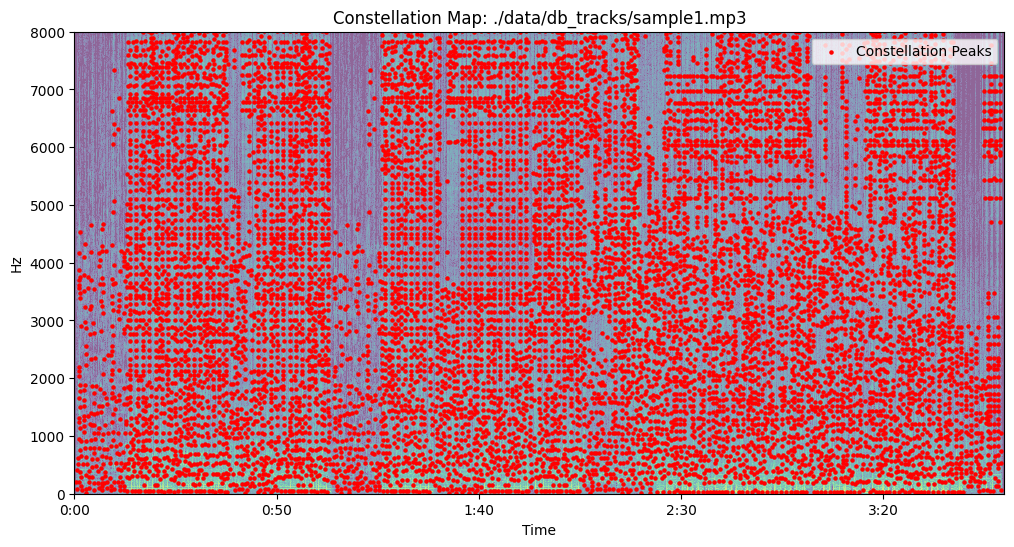

In [77]:
plot_constellation(test_file)

In [6]:
import numpy as np
from collections import defaultdict

class SimpleShazam:
    def __init__(self):
        # The "Database"
        # Key: Hash Token (e.g., "39|16|2")
        # Value: List of (Song_Name, Absolute_Time_in_Song)
        self.database = defaultdict(list)
    
    def add_song(self, song_name, fingerprints):
        """Phase 4: Storage - Index a song into the database."""
        print(f"Indexing {song_name} with {len(fingerprints)} hashes...")
        for hash_token, anchor_time in fingerprints:
            self.database[hash_token].append((song_name, anchor_time))
            
    def match(self, sample_fingerprints):
        """Phase 5: Search & Scoring"""
        
        # 1. Find Matches
        # We look for each hash from the sample in our big database
        matches = []
        
        for hash_token, sample_time in sample_fingerprints:
            if hash_token in self.database:
                # We found a match! Retrieve all locations in the DB
                db_hits = self.database[hash_token]
                
                for song_name, db_time in db_hits:
                    # 2. Calculate Offset (The "Diagonal Line" Logic)
                    # Offset = Database_Time - Sample_Time
                    offset = db_time - sample_time
                    matches.append((song_name, offset))
        
        # 3. Score via Histogram
        # We group matches by Song, then by Offset
        song_scores = defaultdict(lambda: defaultdict(int))
        
        for song_name, offset in matches:
            song_scores[song_name][offset] += 1
            
        # 4. Find the Best Match
        best_song = None
        best_score = 0
        
        for song_name, offsets in song_scores.items():
            # Find the offset with the most hits (the "Peak" in the histogram)
            # This is the height of the spike in Figure 3B of the paper
            max_hits_at_one_offset = max(offsets.values())
            
            if max_hits_at_one_offset > best_score:
                best_score = max_hits_at_one_offset
                best_song = song_name      
        return best_song, best_score

In [9]:
engine = SimpleShazam()

In [8]:
engine.add_song("My Track", fingerprints)

Indexing My Track with 72201 hashes...


In [42]:
snippet_start_index = 5000
snippet_end_index = 5200

# We take the slice
real_clip_data = fingerprints[snippet_start_index:snippet_end_index]

# CRITICAL STEP: Relative Time
# When you record on a phone, the recording starts at "0:00".
# But in the DB, these hashes are at "1:15".
# We must normalize the sample time to start at 0 to simulate a real phone recording.
start_time_of_clip = real_clip_data[0][1] # Time of the first hash

simulated_sample = []
for hash_token, abs_time in real_clip_data:
    normalized_time = abs_time - start_time_of_clip
    simulated_sample.append((hash_token, normalized_time))
    
print(f"\nSimulating a {len(simulated_sample)}-hash clip...")

# 4. Run the Search
song, score = engine.match(simulated_sample)

print("\n--- RESULTS ---")
print(f"Identified Song: {song}")
print(f"Confidence Score: {score}")

if score > 20: 
    print(">> MATCH FOUND! <<")
else:
    print(">> NO MATCH <<")


Simulating a 200-hash clip...

--- RESULTS ---
Identified Song: My Track
Confidence Score: 200
>> MATCH FOUND! <<


In [7]:
import sounddevice as sd
from scipy.io.wavfile import write

def record_audio(duration=10, fs=22050):
    print(f"🎤 Listening for {duration} seconds...")
    
    # Record audio (mono)
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    sd.wait()  # Wait until recording is finished
    
    print("✅ Recording complete.")
    
    # Save to a temporary file (so librosa can load it easily)
    filename = "temp_query.wav"
    # sounddevice returns float32, convert to int16 for wav writing if needed, 
    # but scipy often handles floats fine. Let's stick to standard float save.
    write(filename, fs, recording)
    
    return filename

In [11]:
import sounddevice as sd
from scipy.io.wavfile import write
import os

def record_audio(duration=10, fs=22050):
    print(f"🎤 Listening for {duration} seconds...")
    
    # Record audio (mono)
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    sd.wait()  # Wait until recording is finished
    
    print("✅ Recording complete.")
    
    # Save to a temporary file (so librosa can load it easily)
    filename = "temp_query.wav"
    # sounddevice returns float32, convert to int16 for wav writing if needed, 
    # but scipy often handles floats fine. Let's stick to standard float save.
    write(filename, fs, recording)
    
    return filename

# --- UPDATED MAIN LOOP ---
if __name__ == "__main__":
    # 1. Setup Engine
    engine = SimpleShazam()
    
    # 2. Learn Your Songs (Add more files here!)
    # Make sure to point to your actual MP3 files
    # songs = [
    #     "data/db_tracks/sample6.mp3",
    #     # "data/db_tracks/another_song.mp3"  <-- Add a second song here later
    # ]
    
    path = "./data/db_tracks/" 
    songs = [f"{path}{x}" for x in os.listdir(path)]

    
    for song_path in songs:
        # Generate Constellation
        peaks = generate_constellation_map(song_path)
        # Generate Fingerprints
        fingerprints = create_hashes(peaks)
        # Add to DB
        engine.add_song(song_path, fingerprints)
        
    print(f"\nDatabase ready! Indexed {len(songs)} songs.")
    
    # 3. REAL TEST
    input("Press Enter to start recording...")
    
    # A. Record
    query_file = record_audio(duration=5)
    
    # B. Process the Recording
    print("Processing recording...")
    query_peaks = generate_constellation_map(query_file)
    query_hashes = create_hashes(query_peaks)
    
    # C. Match
    print(f"Extracted {len(query_hashes)} fingerprints from recording.")
    song_match, score = engine.match(query_hashes)
    
    # 4. Result
    print("\n--- 🎵 RESULT 🎵 ---")
    print(f"Best Match: {song_match}")
    print(f"Score: {score}")
    
    # Clean up temp file
    if os.path.exists(query_file):
        os.remove(query_file)

Processing ./data/db_tracks/sample1.mp3...
Found 13386 peaks.
Indexing ./data/db_tracks/sample1.mp3 with 72201 hashes...
Processing ./data/db_tracks/sample10.m4a...


C:\Users\Fiifi Amoah\AppData\Local\Temp\ipykernel_37132\3837842967.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=22050, mono=True)


Found 9175 peaks.
Indexing ./data/db_tracks/sample10.m4a with 55536 hashes...
Processing ./data/db_tracks/sample2.mp3...
Found 9540 peaks.
Indexing ./data/db_tracks/sample2.mp3 with 54240 hashes...
Processing ./data/db_tracks/sample3.m4a...
Found 7855 peaks.
Indexing ./data/db_tracks/sample3.m4a with 40032 hashes...
Processing ./data/db_tracks/sample4.mp3...
Found 12928 peaks.
Indexing ./data/db_tracks/sample4.mp3 with 66695 hashes...
Processing ./data/db_tracks/sample5.mp3...
Found 12172 peaks.
Indexing ./data/db_tracks/sample5.mp3 with 66187 hashes...
Processing ./data/db_tracks/sample6.mp3...
Found 11771 peaks.
Indexing ./data/db_tracks/sample6.mp3 with 64324 hashes...
Processing ./data/db_tracks/sample7.m4a...
Found 6000 peaks.
Indexing ./data/db_tracks/sample7.m4a with 36186 hashes...
Processing ./data/db_tracks/sample8.mp3...
Found 17889 peaks.
Indexing ./data/db_tracks/sample8.mp3 with 112755 hashes...
Processing ./data/db_tracks/sample9.mp3...
Found 4561 peaks.
Indexing ./data/